In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from time import time
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
pd.options.display.max_columns = None
pd.options.display.max_rows = None
matplotlib.rcParams.update({'font.size': 22})
from pytz import timezone as tz

In [18]:
data_path = "./data/"
data_freq = "H"
max_epochs = 10
patience = 10
learning_rate = 0.01

end_train_date = datetime(2018, 8, 30)
nb_hours_pred = 7*24

In [3]:
df = pd.read_csv(data_path + "eco2mix-regional-cons-def.csv", sep=";",
                parse_dates=["Date - Heure"],
                usecols=["Région", "Date - Heure", "Consommation (MW)"]).sort_values(
    by=["Région", "Date - Heure"])

In [4]:
pd.isnull(df["Consommation (MW)"]).value_counts()

False    1401972
True          12
Name: Consommation (MW), dtype: int64

In [5]:
df.rename(columns={"Date - Heure": "Date"}, inplace=True)
df.fillna(0, inplace=True)
df["date_heure"] = df["Date"].apply(lambda x: x + timedelta(minutes=x.minute))
df["date_heure"] = df["date_heure"].apply(lambda x: x.astimezone(tz("UTC")))
df["date_heure"] = df["date_heure"].apply(lambda x: x.fromtimestamp(x.timestamp()))
df.head(3)

,Région,Date,Consommation (MW),date_heure
1288256,Auvergne-Rhône-Alpes,2013-01-01 00:00:00+01:00,0.0,2013-01-01 00:00:00
1288257,Auvergne-Rhône-Alpes,2013-01-01 00:30:00+01:00,8173.0,2013-01-01 01:00:00
116935,Auvergne-Rhône-Alpes,2013-01-01 01:00:00+01:00,7944.0,2013-01-01 01:00:00


In [6]:
df_hour = df.groupby(["Région", "date_heure"], as_index=False).agg({"Consommation (MW)": np.sum})
df_hour.head(3)

,Région,date_heure,Consommation (MW)
0,Auvergne-Rhône-Alpes,2013-01-01 00:00:00,0.0
1,Auvergne-Rhône-Alpes,2013-01-01 01:00:00,16117.0
2,Auvergne-Rhône-Alpes,2013-01-01 02:00:00,15778.0


In [7]:
df_hour["Région"].value_counts()

Nouvelle-Aquitaine            58410
Grand-Est                     58410
Bourgogne-Franche-Comté       58410
Pays de la Loire              58410
Centre-Val de Loire           58410
Auvergne-Rhône-Alpes          58410
Hauts-de-France               58410
Ile-de-France                 58410
Occitanie                     58410
Provence-Alpes-Côte d'Azur    58410
Bretagne                      58410
Normandie                     58410
Name: Région, dtype: int64

In [8]:
print(df_hour["date_heure"].min(), df_hour["date_heure"].max())

2013-01-01 00:00:00 2019-09-01 00:00:00


C:\Users\vincent_villet\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


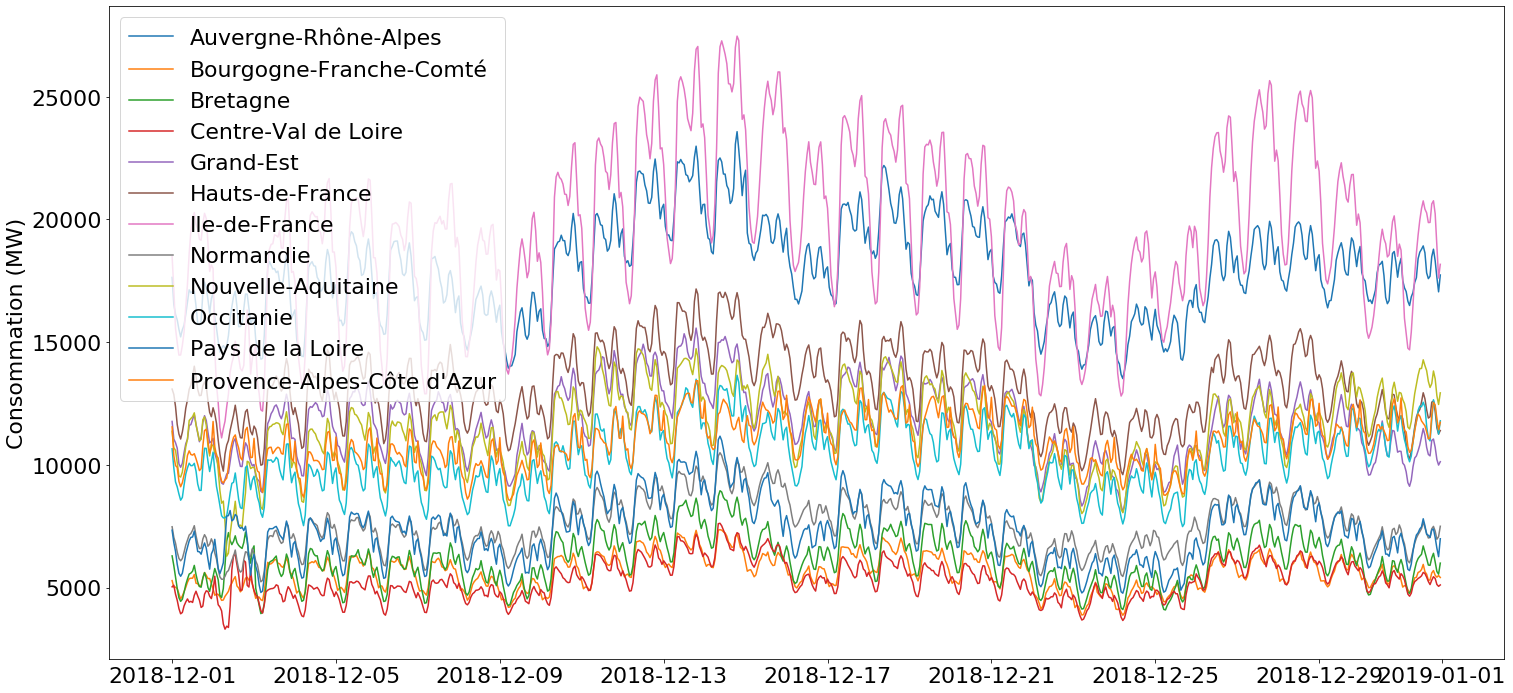

In [9]:
matplotlib.rcParams.update({'font.size': 22})
year = 2018
month = 12

plt.figure(1, figsize=(25, 12))
for region in pd.unique(df_hour["Région"]):
    df_region = df_hour[(df_hour["Région"]==region)
                        &(df_hour["date_heure"].apply(lambda x: x.year)==year)
                       &(df_hour["date_heure"].apply(lambda x: x.month==month))]
    plt.plot(df_region["date_heure"], df_region["Consommation (MW)"], label=region)
    plt.ylabel("Consommation (MW)")
    plt.legend()

plt.show()

In [10]:
df_dict = {}

for region in pd.unique(df_hour["Région"]):
    df_dict[region] = df_hour[df_hour["Région"]==region].copy().reset_index(drop=True)
    df_dict[region].index = df_dict[region]["date_heure"]
    df_dict[region] = df_dict[region].reindex(
        pd.date_range(start=df_hour["date_heure"].min(), end=df_hour["date_heure"].max(), freq=data_freq)).drop(
        ["date_heure", "Région"], axis=1)

In [11]:
df_dict["Auvergne-Rhône-Alpes"].head(3)

,Consommation (MW)
2013-01-01 00:00:00,0.0
2013-01-01 01:00:00,16117.0
2013-01-01 02:00:00,15778.0


# Fonctions pour entraînement DeepAR

In [19]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions

def train_predictor(df_dict, end_train_date, regions_list, feat_dynamic_cols=None):
    estimator = DeepAREstimator(freq=data_freq, 
                                prediction_length=nb_hours_pred,
                                trainer=Trainer(epochs=max_epochs, learning_rate = learning_rate,
                                                learning_rate_decay_factor=0.01, patience=patience),
                                use_feat_dynamic_real=feat_dynamic_cols is not None)
    if feat_dynamic_cols is not None:
        
        training_data = ListDataset(
            [{"item_id": region,
                "start": df_dict[region].index[0],
              "target": df_dict[region]["Consommation (MW)"][:end_train_date],
             "feat_dynamic_real": [df_dict[region][feat_dynamic_col][:end_train_date]
                                   for feat_dynamic_col in feat_dynamic_cols] 
             }
            for region in regions_list],
            freq = data_freq
        )
    else:
        training_data = ListDataset(
            [{"item_id": region,
                "start": df_dict[region].index[0],
              "target": df_dict[region]["Consommation (MW)"][:end_train_date]
             }
            for region in regions_list],
            freq = data_freq
        )

    predictor = estimator.train(training_data=training_data)
    
    return predictor


def make_predictions(predictor, df_dict, test_date, regions_list, feat_dynamic_cols=None):
    if feat_dynamic_cols is not None:
        test_data = ListDataset(
            [{"item_id": region,
                "start": df_dict[region].index[0],
              "target": df_dict[region]["Consommation (MW)"][:test_date + timedelta(hours=nb_hours_pred)],
             "feat_dynamic_real": [df_dict[region][feat_dynamic_col][:test_date + timedelta(hours=nb_hours_pred)]
                                   for feat_dynamic_col in feat_dynamic_cols]
             }
            for region in regions_list],
            freq = data_freq
            )
    else:
         test_data = ListDataset(
            [{"item_id": region,
                "start": df_dict[region].index[0],
              "target": df_dict[region]["Consommation (MW)"][:test_date + timedelta(hours=nb_hours_pred)],
             }
            for region in regions_list],
            freq = data_freq
            )

    forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=predictor, num_eval_samples=100)
    
    return list(forecast_it), list(ts_it)


def plot_forecasts(df_dict, test_date, tss, forecasts, past_length, num_plots):
    for target, forecast in zip(tss, forecasts):
        ax = target[-past_length:].plot(figsize=(20, 8), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.title(forecast.item_id)
        plt.show()

# Test

In [20]:
idf_list = ["Ile-de-France"]

idf_predictor = train_predictor(df_dict, end_train_date, idf_list, feat_dynamic_cols=None)

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.01
100%|█████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.47it/s, avg_epoch_loss=9.66]
INFO:root:Epoch[0] Elapsed time 34.056 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=9.657207
INFO:root:Epoch[1] Learning rate is 0.01
100%|█████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.43it/s, avg_epoch_loss=8.69]
INFO:root:Epoch[1] Elapsed time 34.934 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=8.694012
INFO:root:Epoch[2] Learning rate is 0.01
100%|██████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.44it/s, avg_epoch_loss=8.5]
INFO:root:Epoch[2] Elapsed time 34.817 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=8.503737
INFO:root:Epoch[3] Learning rate is 0.01
100%|███████████████████████████████████████

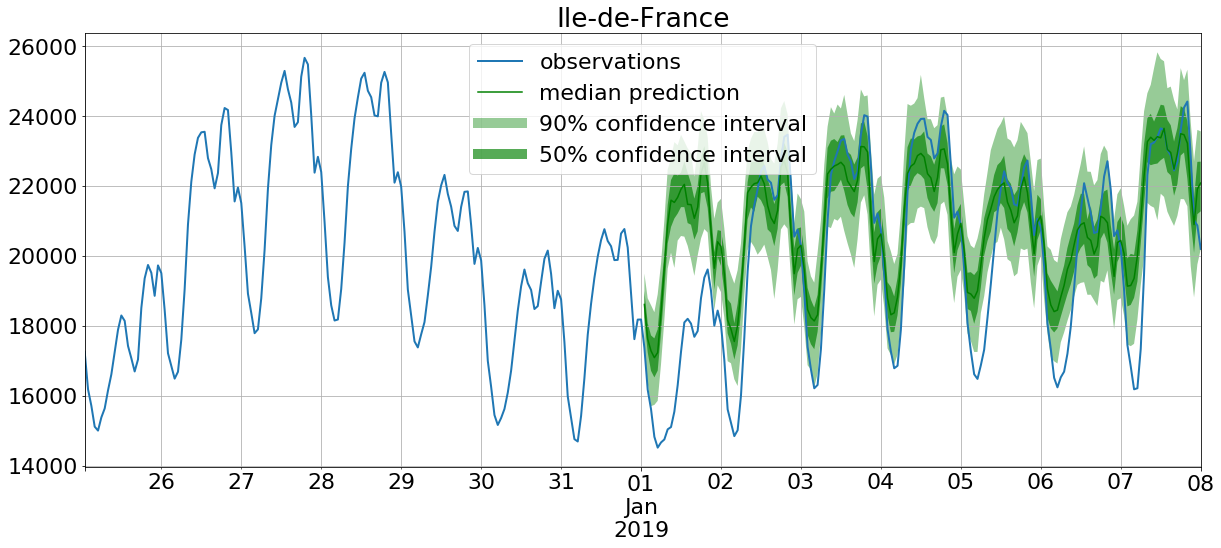

In [21]:
matplotlib.rcParams.update({'font.size': 22})
test_date = datetime(2019, 1, 1)
forecasts, tss = make_predictions(idf_predictor, df_dict, test_date, idf_list)
plot_forecasts(df_dict, test_date, tss, forecasts, past_length=2*nb_hours_pred, num_plots=1)

In [24]:
all_regions = pd.unique(df["Région"])

all_reg_predictor = train_predictor(df_dict, end_train_date, all_regions, feat_dynamic_cols=None)

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.01
100%|█████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.46it/s, avg_epoch_loss=8.95]
INFO:root:Epoch[0] Elapsed time 34.284 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.953187
INFO:root:Epoch[1] Learning rate is 0.01
100%|█████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.49it/s, avg_epoch_loss=8.18]
INFO:root:Epoch[1] Elapsed time 32.646 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=8.176141
INFO:root:Epoch[2] Learning rate is 0.01
100%|█████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.50it/s, avg_epoch_loss=7.75]
INFO:root:Epoch[2] Elapsed time 32.379 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.746657
INFO:root:Epoch[3] Learning rate is 0.01
100%|███████████████████████████████████████

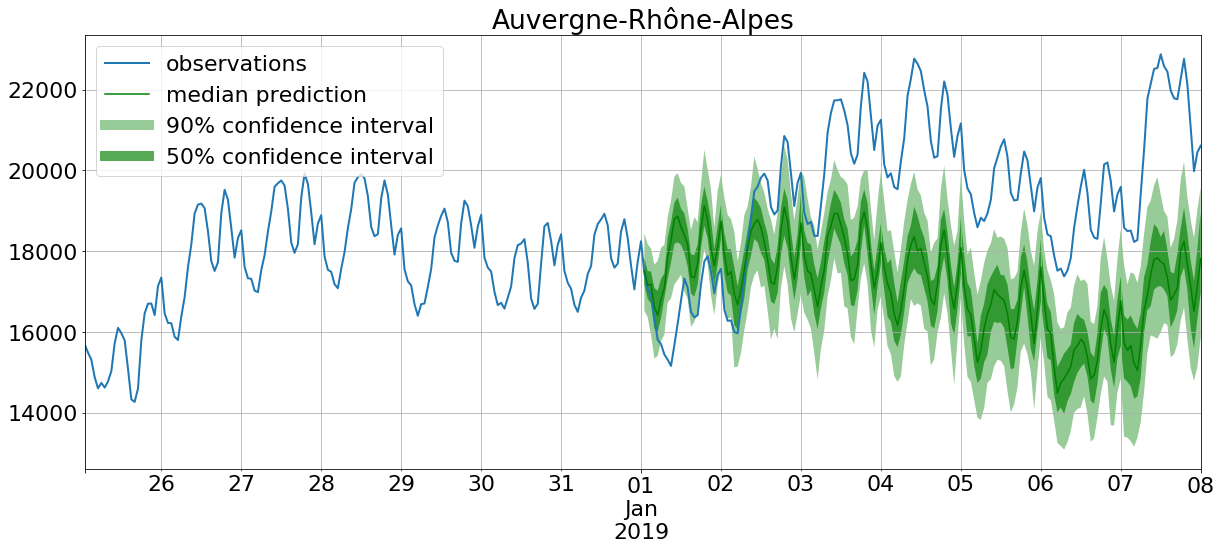

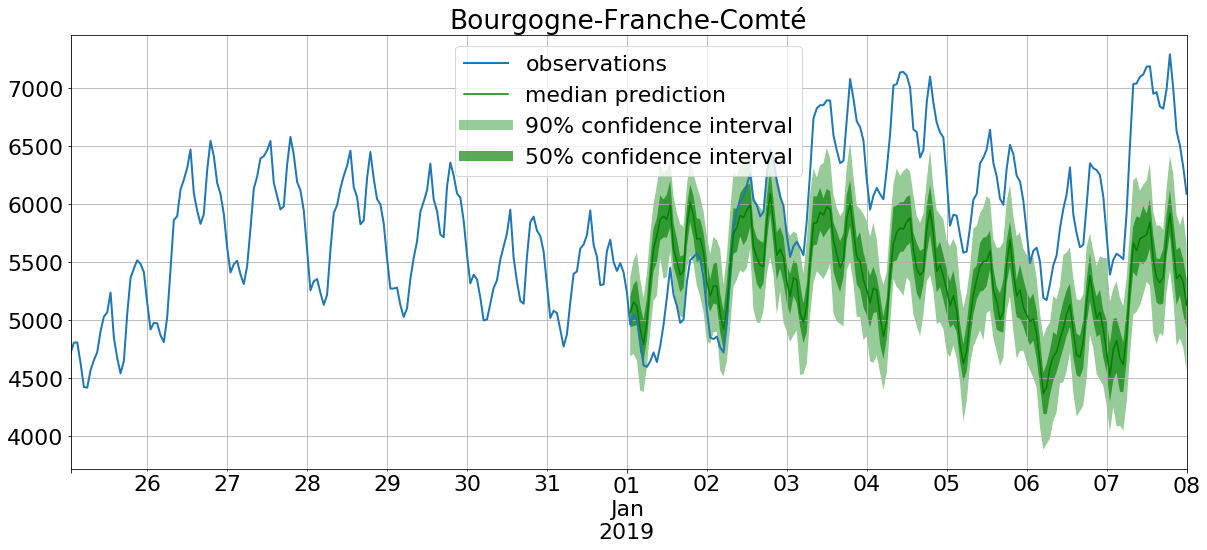

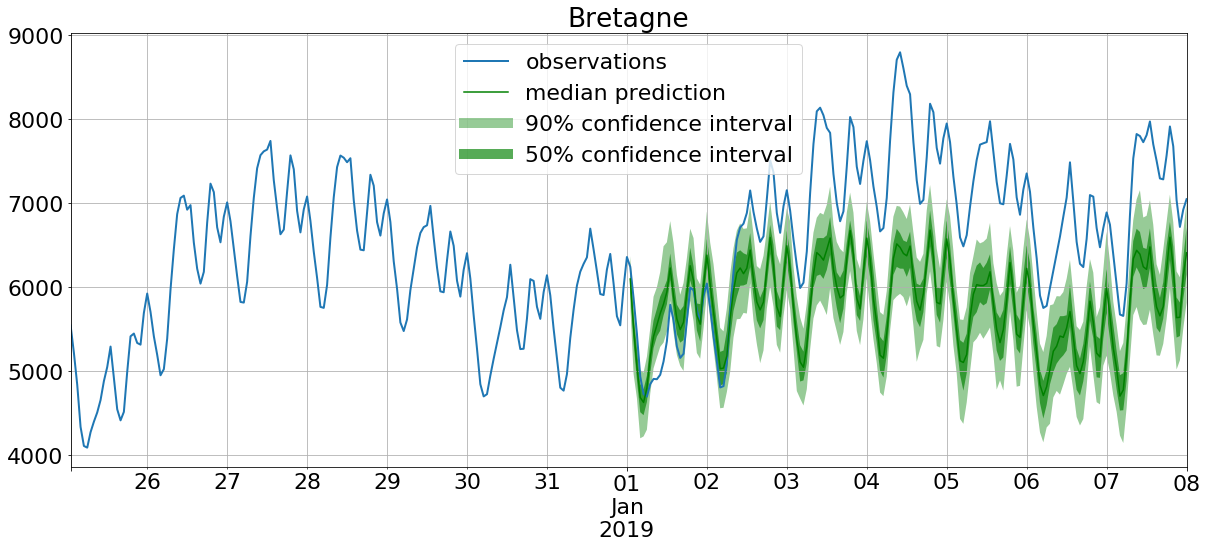

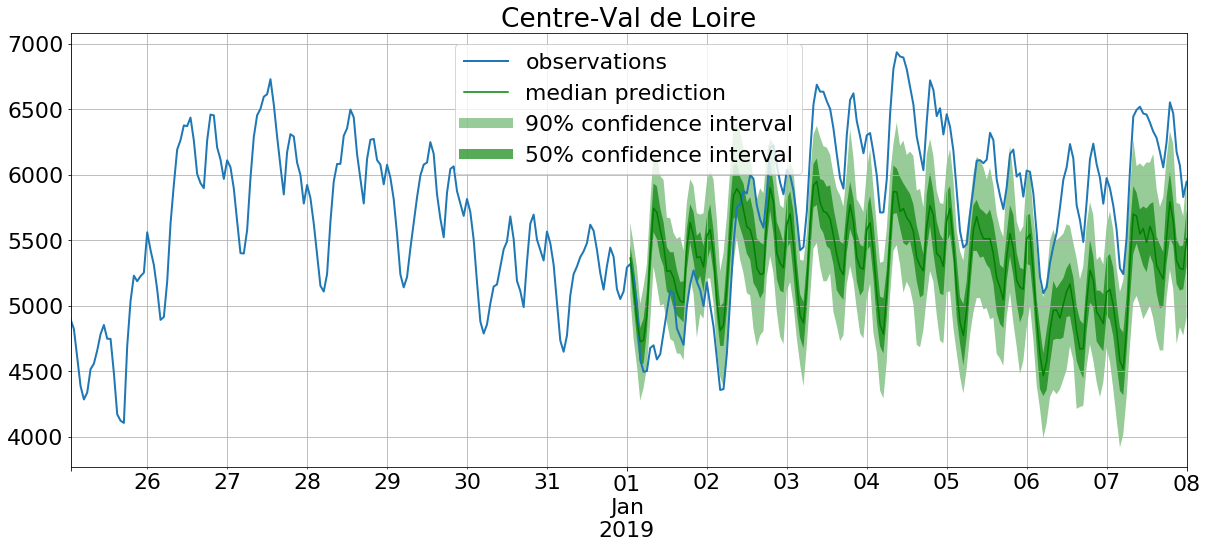

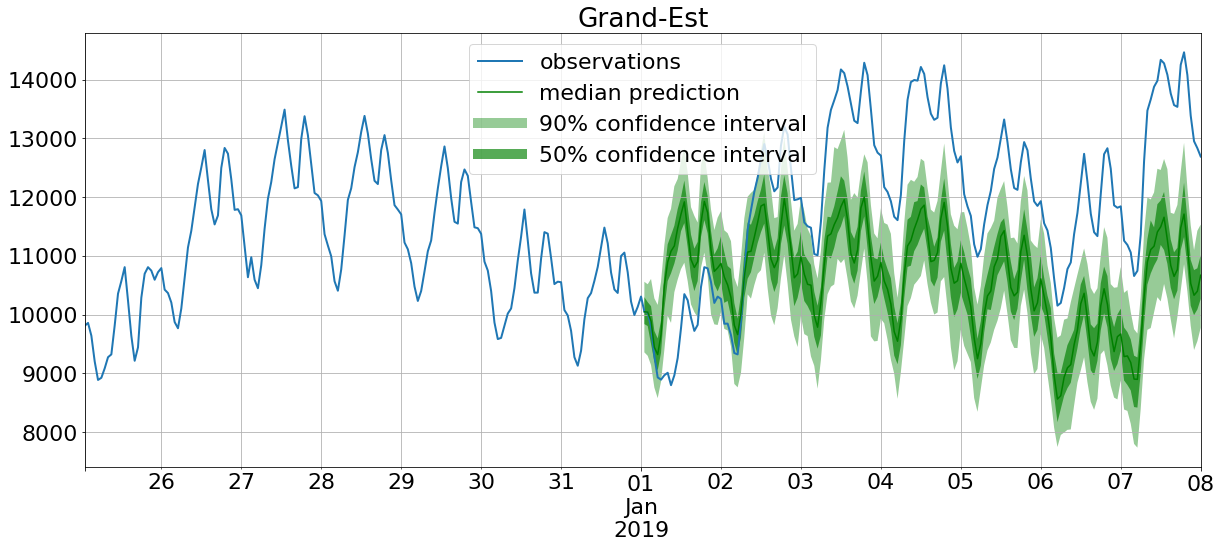

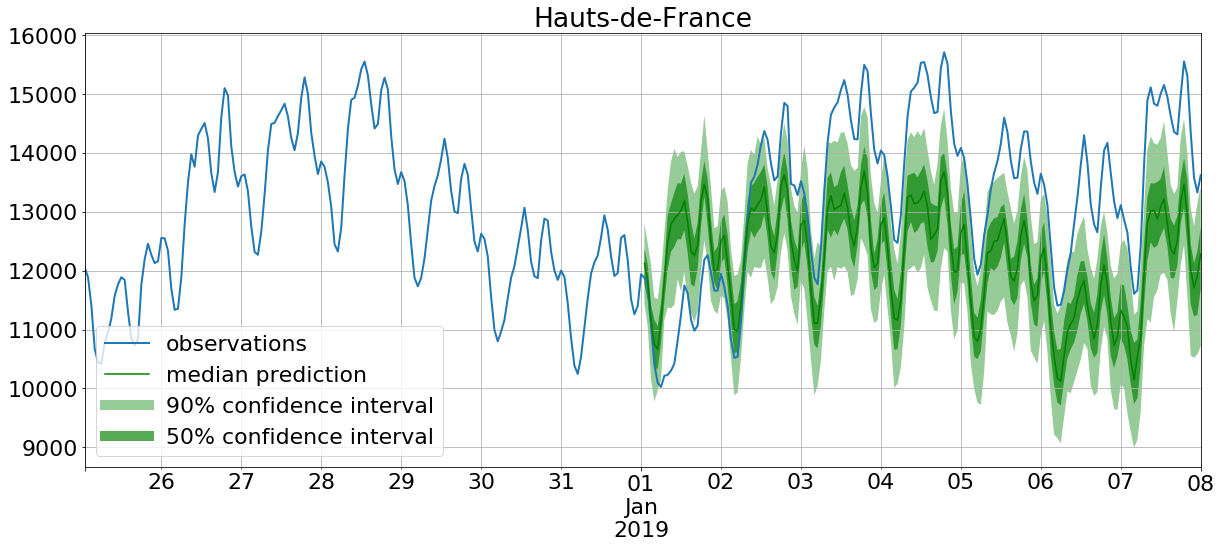

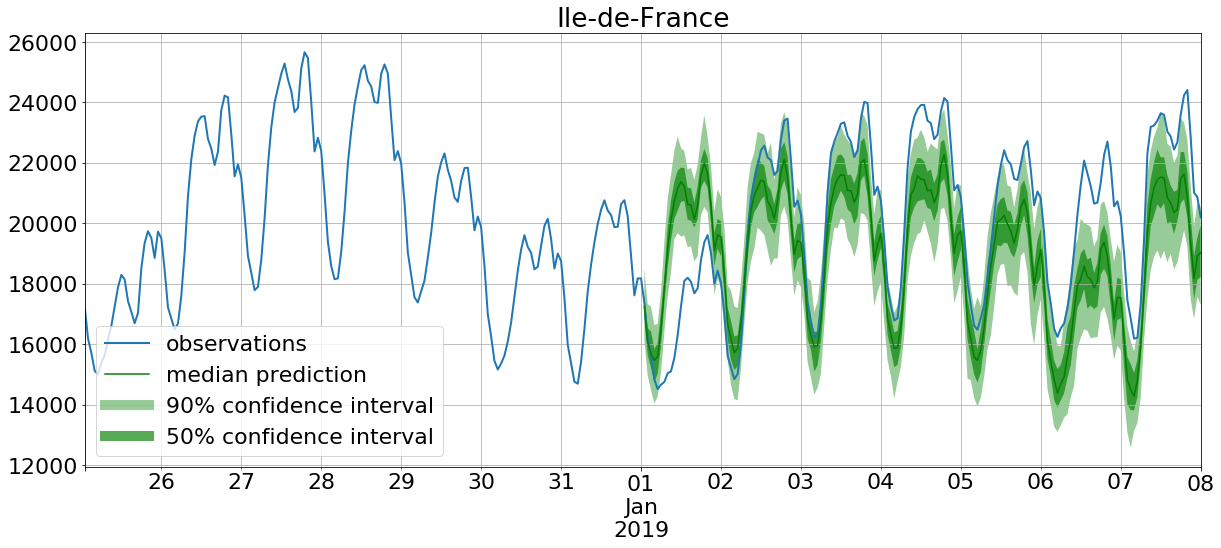

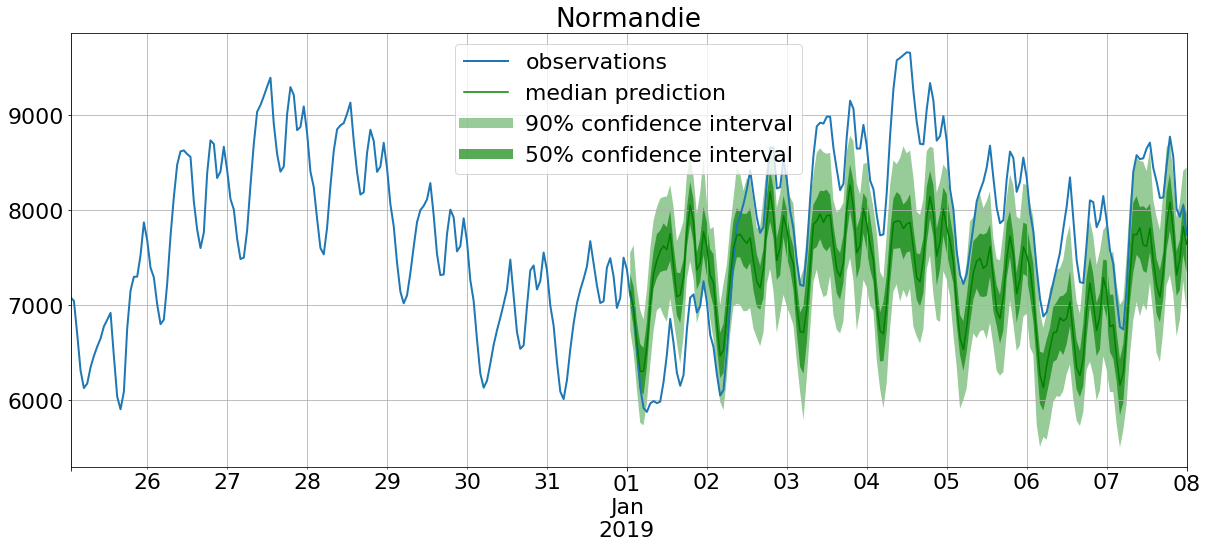

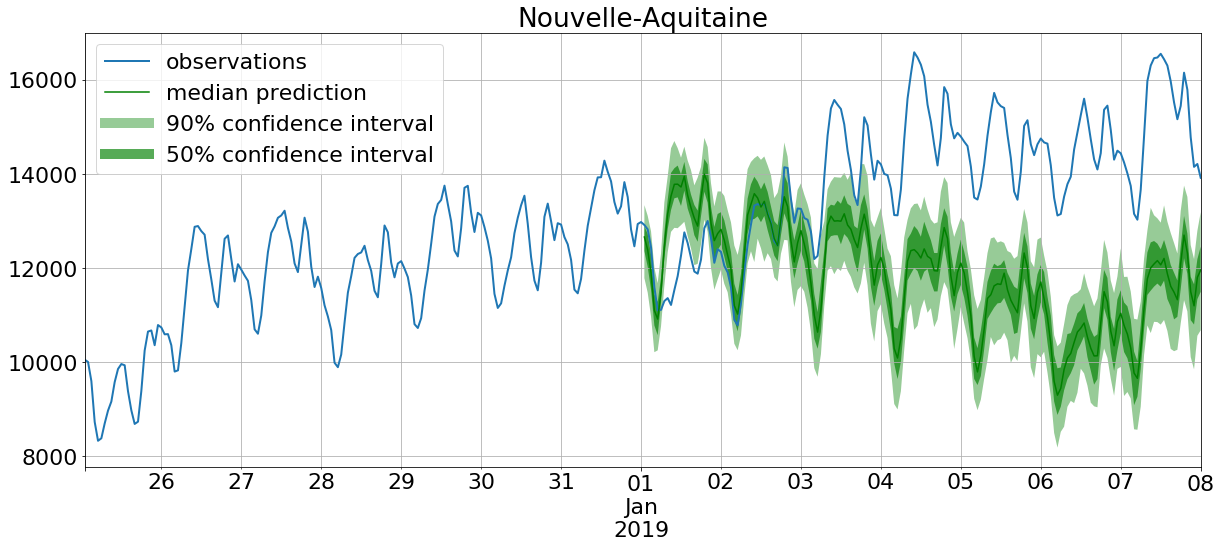

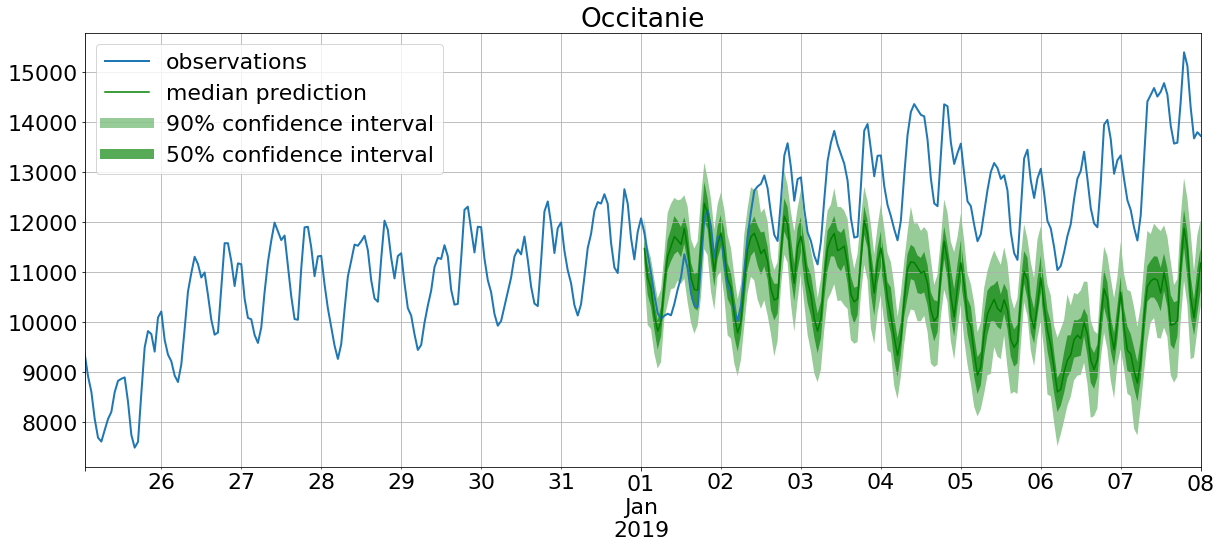

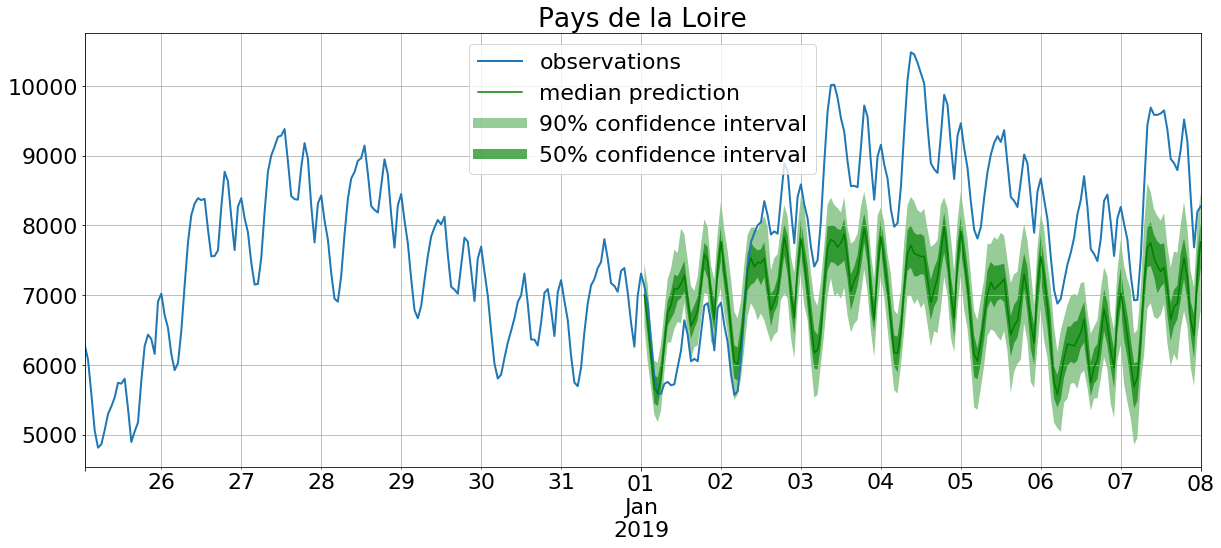

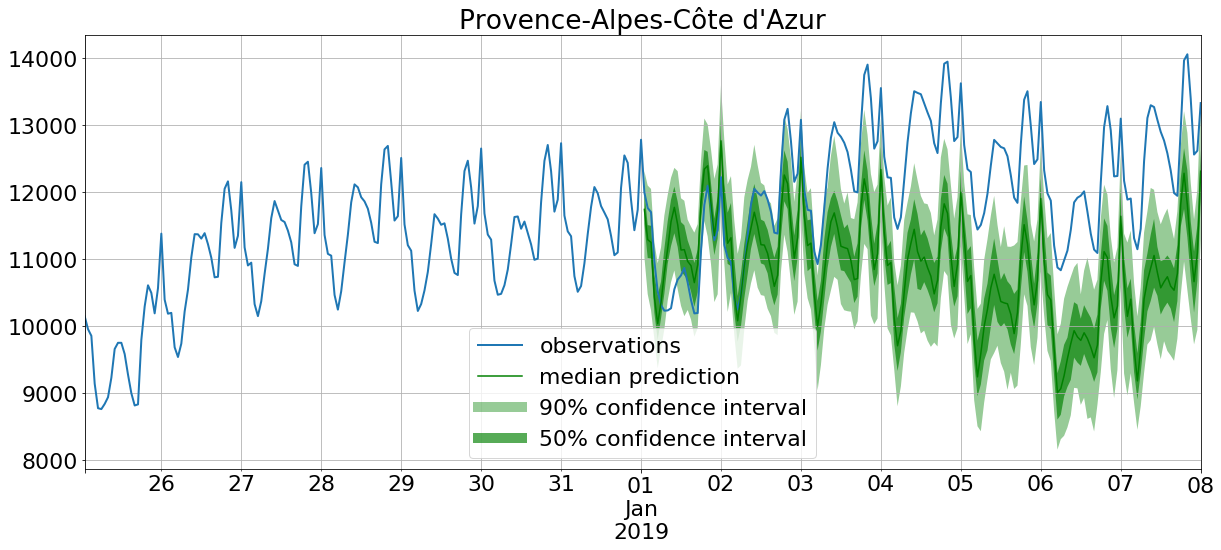

In [25]:
matplotlib.rcParams.update({'font.size': 22})
test_date = datetime(2019, 1, 1)
forecasts, tss = make_predictions(all_reg_predictor, df_dict, test_date, all_regions)
plot_forecasts(df_dict, test_date, tss, forecasts, past_length=2*nb_hours_pred, num_plots=1)